This notebook shows how to use the CNN-LSTM model to predict the global temperature map.

By Weiwei Zhan

Reference: https://github.com/duncanwp/ClimateBench/blob/main/baseline_models/CNN-LTSM_model.ipynb

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-09-20 18:49:10.950606: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 18:49:11.454230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocessing: prepare data for training & test sets

#### import data as training & test sets

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### select relevant variables

predictors: CO2, CH4, **SO2, BC (black carbon)** <br/>
predictand: tas

**Note:** we here include *two additional predictors*: SO2 & BC. SO2 & BC inputs are 2-D maps, while CO2 & CH4 are 1-D time series

In [4]:
y_train_np = y_train_xr['tas'].data
y_test_np  = y_test_xr['tas'].data

#### Data Normalization

In [5]:
# Compute mean/std of each variable for the whole dataset
meanstd_inputs = {}
predictors     = ['CO2', 'CH4', 'SO2', 'BC']
for var in predictors:
    meanstd_inputs[var] = (X_train_xr[var].data.mean(),X_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = X_train_xr[var].dims
    X_train_xr = X_train_xr.assign({var: (var_dims, normalize(X_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = X_test_xr[var].dims
    X_test_xr = X_test_xr.assign({var: (var_dims, normalize(X_test_xr[var].data, var, meanstd_inputs))})

In [6]:
X_train_np = X_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
X_test_np  = X_test_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

print(X_train_np.shape,y_train_np.shape,X_test_np.shape,y_test_np.shape)

(753, 96, 144, 4) (753, 96, 144) (86, 96, 144, 4) (86, 96, 144)


Reshape data to feed into the LSTM model

The LSTM needs data with the format of **[samples, time steps, n_latitude, n_longitude, n_features]**

Here the lag time step is set to **5**

In [7]:
start = np.cumsum(X_length) - X_length
end   = np.cumsum(X_length)

slider = 5
n_samples   = X_train_np.shape[0] - (slider-1)*len(X_length)
n_lat,n_lon,n_feature = X_train_np.shape[1:]

X_train = np.zeros([n_samples,slider,n_lat,n_lon,n_feature])
y_train = np.zeros([n_samples,1,n_lat,n_lon])

n_start = 0
for i in range(len(X_length)):
    
    X_subset = X_train_np[start[i]:end[i],:]
    y_subset = y_train_np[start[i]:end[i],:]
    
    X_subset = np.array([X_subset[i:i+slider] for i in range(0, X_length[i]-slider+1)])
    y_subset = np.array([[y_subset[i+slider-1]] for i in range(0, X_length[i]-slider+1)])
    
    # print(X_subset.shape,y_subset.shape)
    n_length = X_subset.shape[0]
    X_train[n_start:n_start+n_length,:,:,:,:] = X_subset
    y_train[n_start:n_start+n_length,:,:,:]   = y_subset
    n_start += n_length
    
X_test  = np.array([X_test_np[i:i+slider] for i in range(0, X_test_np.shape[0]-slider+1)])


In [8]:
print(X_train.shape,y_train.shape,X_test.shape)

(729, 5, 96, 144, 4) (729, 1, 96, 144) (82, 5, 96, 144, 4)


### 2. Define the CNN-LSTM structure

In [9]:
n_filters   = 20 # number of filters
kernel_size = 3  # kernel size for Covolutional layers
pool_size   = 2  # size for average pooling layers
n_lstm_unit = 25 # number of LSTM units
activation  = 'relu' # activation function
learning_rate = 0.001 # learning rate
minibatch_size = 64   # batch size
num_epochs     = 50   # number of total epochs

In [10]:
### model using mse as loss function
model_mse = Sequential()

model_mse.add(Input(shape=(slider, n_lat,n_lon,n_feature)))
model_mse.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
model_mse.add(TimeDistributed(AveragePooling2D(pool_size)))
model_mse.add(TimeDistributed(GlobalAveragePooling2D()))
model_mse.add(LSTM(n_lstm_unit, activation=activation))
model_mse.add(Dense(n_lat*n_lon))
model_mse.add(Activation('linear'))
model_mse.add(Reshape((1, n_lat, n_lon)))


model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mse.summary()

### ----------------------------------------------------------------------------------------
### model using mae as loss function
model_mae = Sequential()

model_mae.add(Input(shape=(slider, n_lat,n_lon,n_feature)))
model_mae.add(TimeDistributed(Conv2D(n_filters, (kernel_size, kernel_size), 
                                     padding='same', activation=activation), input_shape=(slider, n_lat,n_lon,n_feature)))
model_mae.add(TimeDistributed(AveragePooling2D(pool_size)))
model_mae.add(TimeDistributed(GlobalAveragePooling2D()))
model_mae.add(LSTM(n_lstm_unit, activation=activation))
model_mae.add(Dense(n_lat*n_lon))
model_mae.add(Activation('linear'))
model_mae.add(Reshape((1, n_lat, n_lon)))


model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mae.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 5, 96, 144, 20)   740       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 48, 72, 20)    0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 20)            0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 25)                4600      
                                                                 
 dense (Dense)               (None, 13824)             359424    
                                                        

### 3. Train & save the model

In [11]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
###------------mse------------
history_mse = model_mse.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])
###------------mae------------
history_mae = model_mae.fit(X_train, y_train, 
                    batch_size = minibatch_size,
                    epochs = num_epochs,
                    validation_split=0.2, verbose=1,
                    callbacks=[early_stop])


Epoch 1/50
10/10 [==============================] - 30s 2s/step - loss: 3.8071 - val_loss: 0.4793
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 3.6869 - val_loss: 0.5113
Epoch 3/50
10/10 [==============================] - 13s 1s/step - loss: 3.2578 - val_loss: 0.6228
Epoch 4/50
10/10 [==============================] - 12s 1s/step - loss: 1.9373 - val_loss: 0.8356
Epoch 5/50
10/10 [==============================] - 13s 1s/step - loss: 1.1815 - val_loss: 0.7902
Epoch 6/50
10/10 [==============================] - 12s 1s/step - loss: 0.7614 - val_loss: 0.8618
Epoch 7/50
10/10 [==============================] - 12s 1s/step - loss: 0.5677 - val_loss: 0.8278
Epoch 8/50
10/10 [==============================] - 13s 1s/step - loss: 0.4551 - val_loss: 0.8434
Epoch 9/50
10/10 [==============================] - 13s 1s/step - loss: 0.3992 - val_loss: 0.7537
Epoch 10/50
10/10 [==============================] - 13s 1s/step - loss: 0.3738 - val_loss: 0.6580
Epoch 11/50
10/10 [

In [12]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [13]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_mse.save(os.path.join(model_path,'CNN-LSTM_model_mse.h5'))
model_mae.save(os.path.join(model_path,'CNN-LSTM_model_mae.h5'))

### 4. Evaluate the trained model

In [14]:
# reload the saved model
model_mse = load_model(os.path.join(model_path,'CNN-LSTM_model_mse.h5'))
model_mae = load_model(os.path.join(model_path,'CNN-LSTM_model_mae.h5'))

In [16]:
###------------mse------------
y_test_mse_pre = model_mse.predict(X_test)
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 96, 144)
y_test_mse_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_mse_pre)))
###------------mae------------
y_test_mae_pre = model_mae.predict(X_test)
y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], 96, 144)
y_test_mae_pre = xr.Dataset(coords={'time': X_test_xr.time.values[slider-1:], 
                               'latitude': X_test_xr.latitude.values, 
                               'longitude': X_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_mae_pre)))

3/3 [==============================] - 2s 106ms/step


First we check whether the ML model can capture the spatial distribution of global temperature

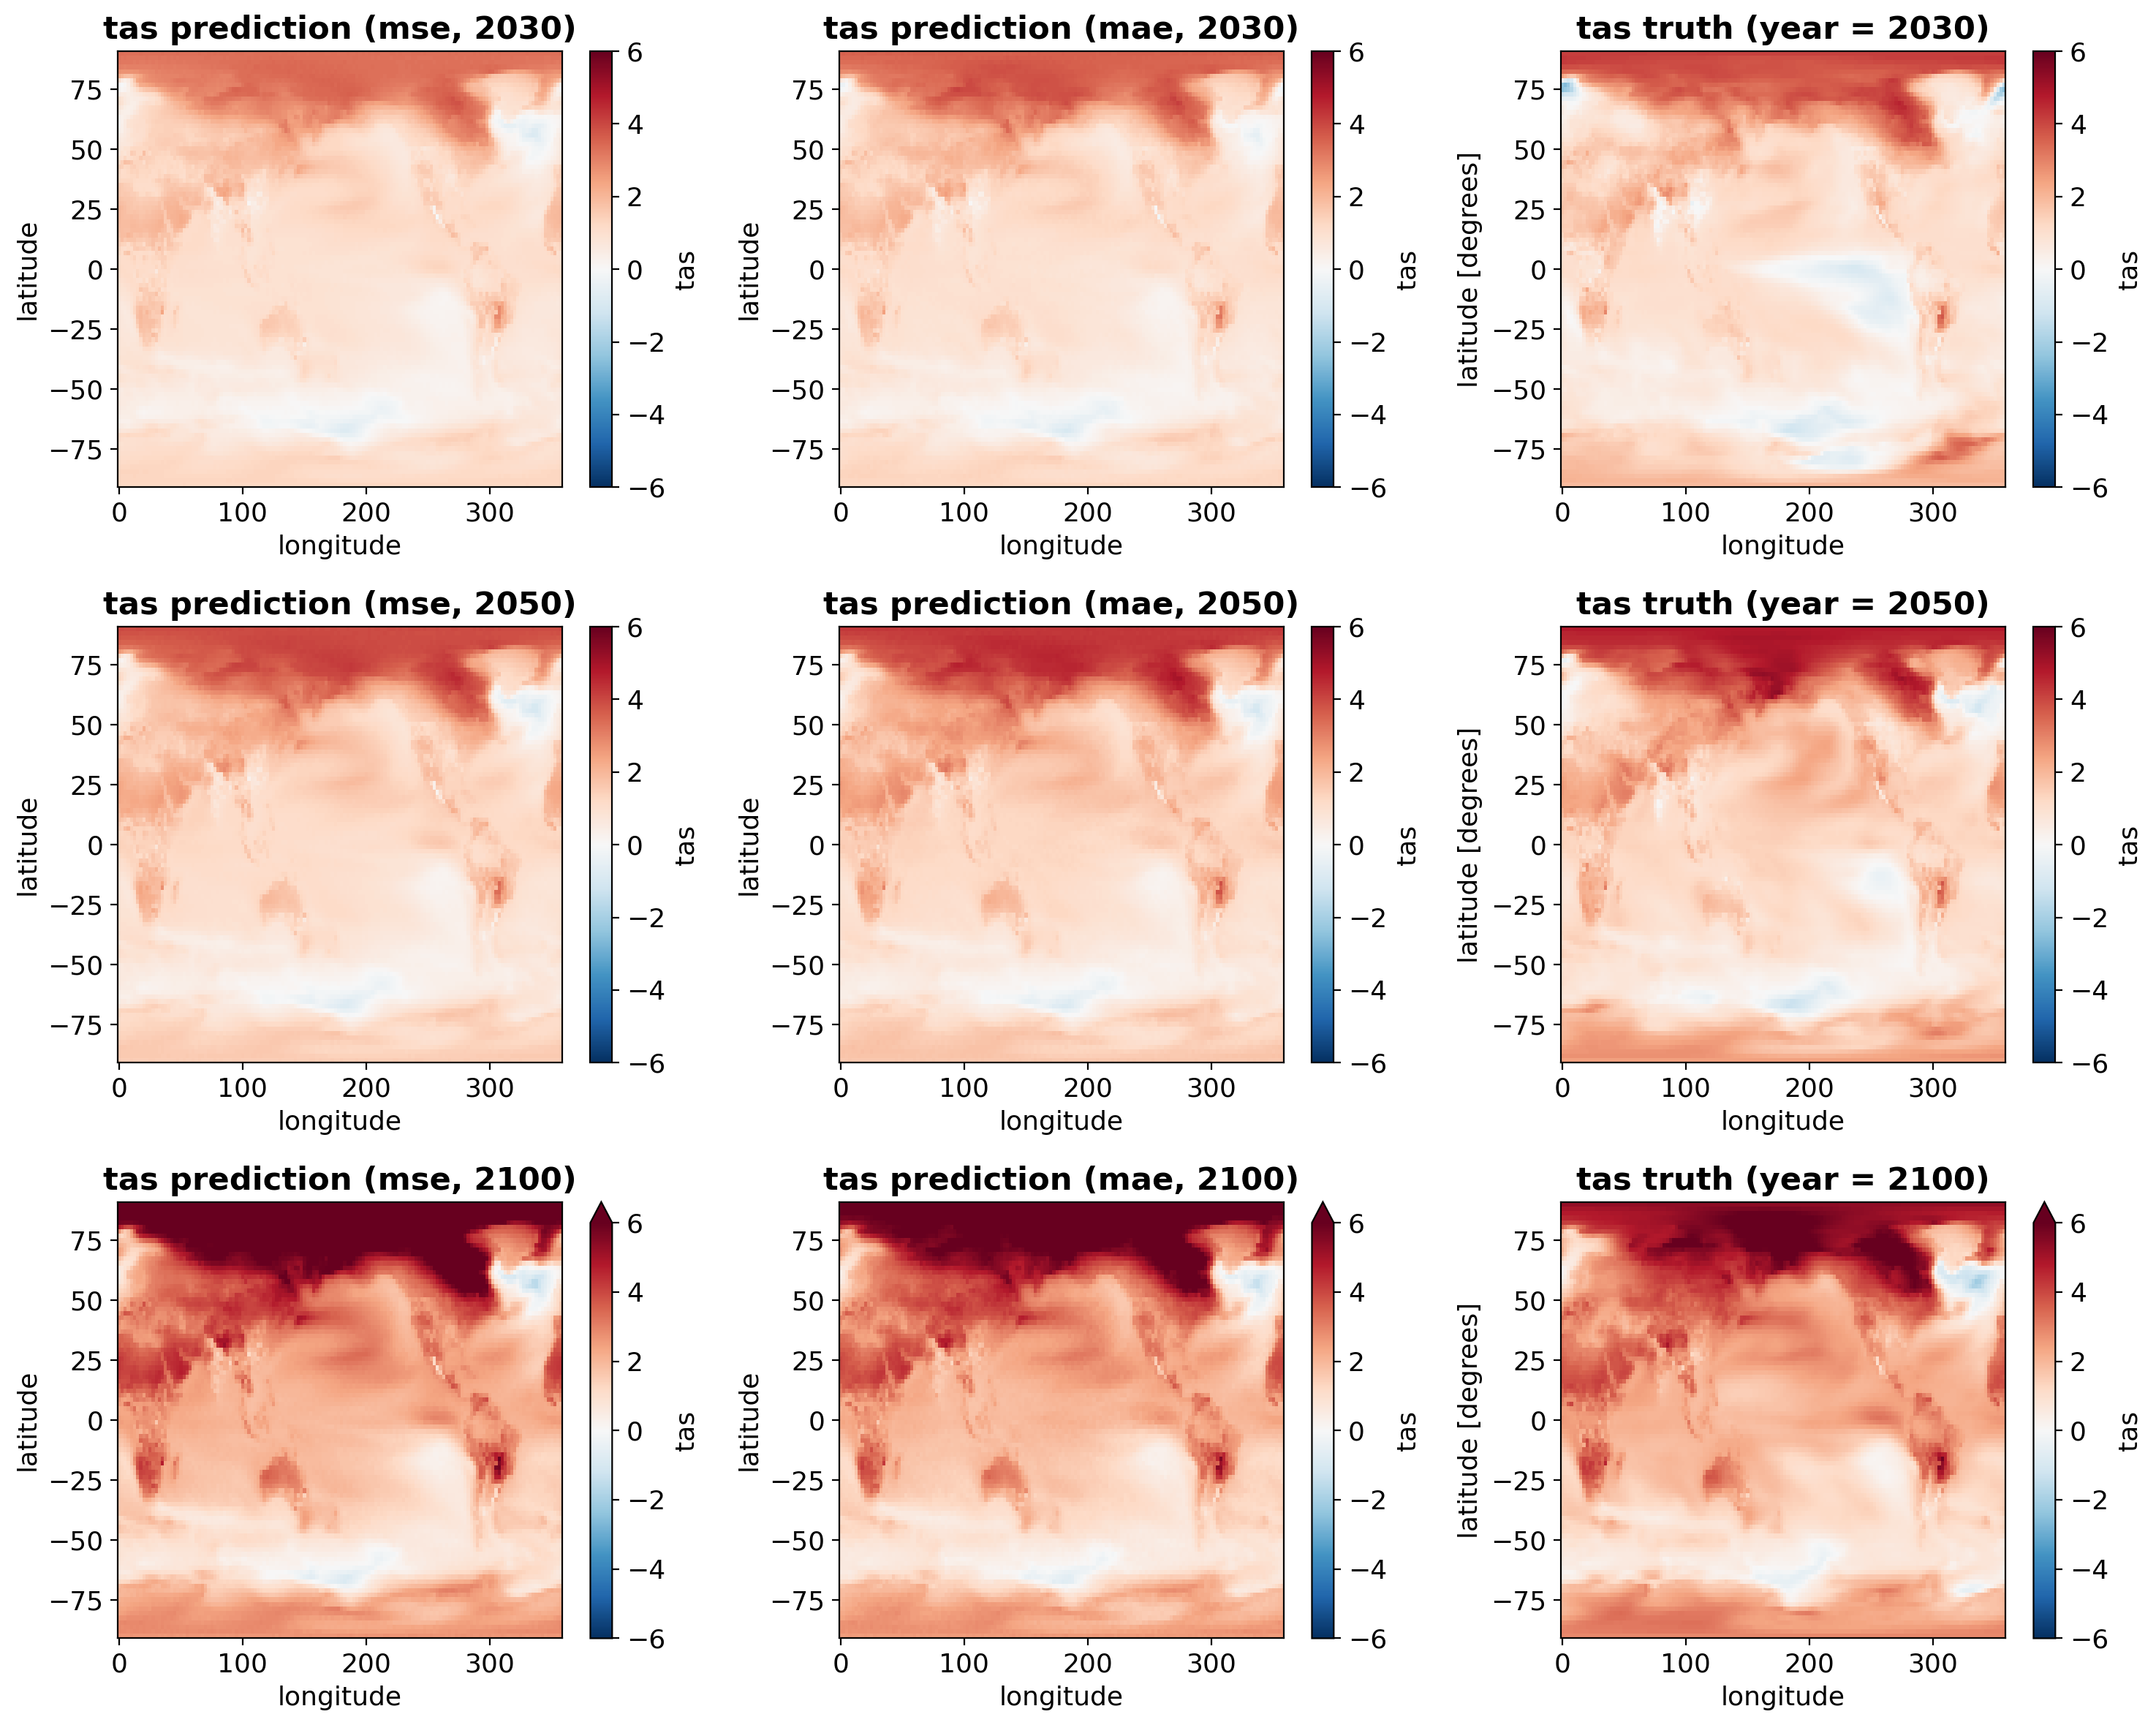

In [27]:
fig, axes = plt.subplots(figsize=(15,12),ncols=3,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_mse_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,2], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_mse_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_mae_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,2], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 3 == 0:
        ax.set_title(f'tas prediction (mse, {yrs[i//3]})',fontweight='bold')
    # middle column: model prediction
    elif i % 3 == 1:
        ax.set_title(f'tas prediction (mae, {yrs[i//3]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//3]})',fontweight='bold')
plt.tight_layout()

Then we also check whether the ML model can reproduce the time series of a given location.<br/> Here we take NYC as an example (40.7128° N, 74.0060° W)

Text(0, 0.5, 'temperature (°C)')

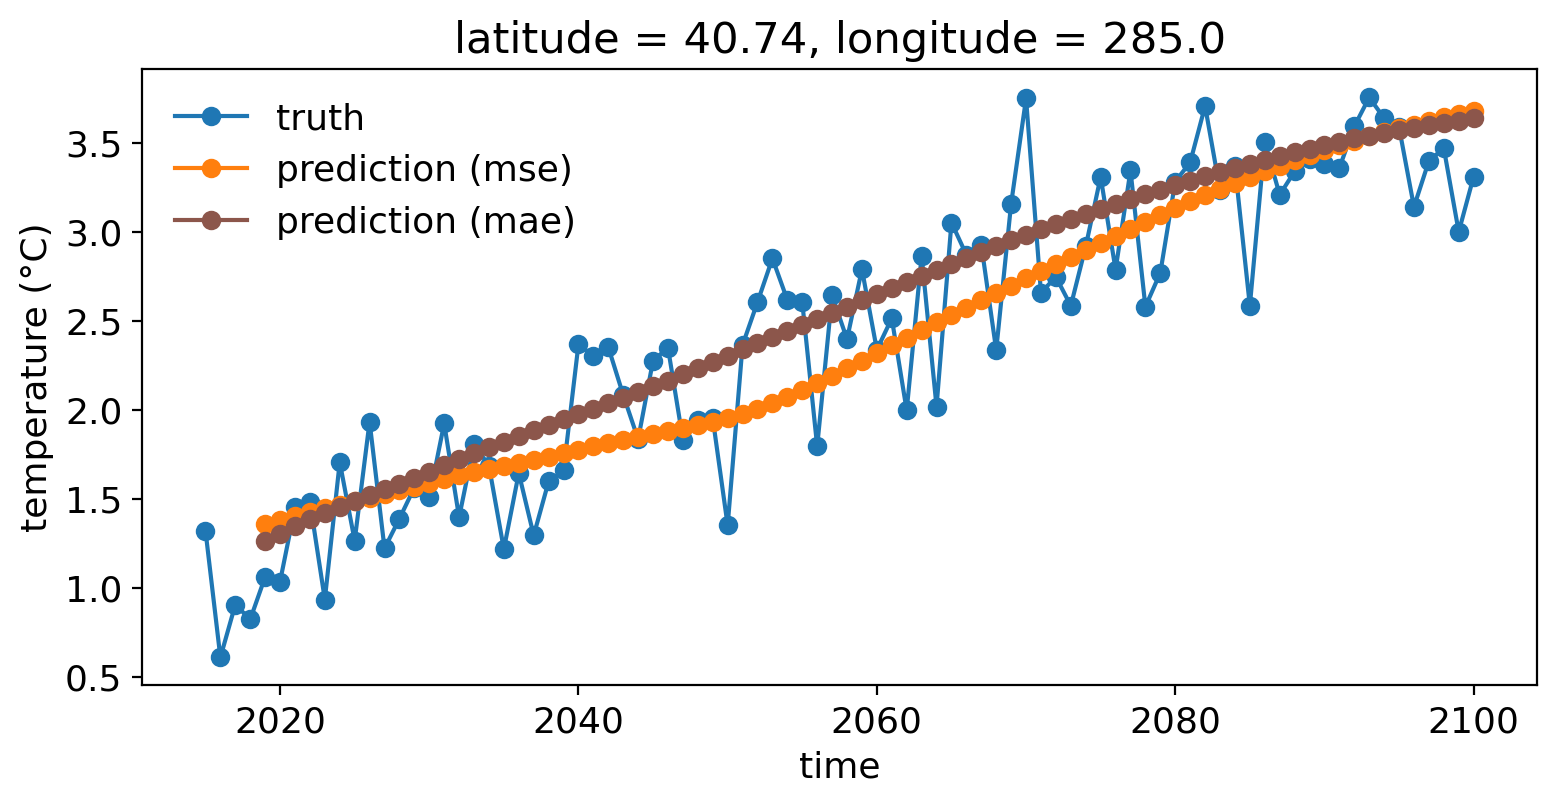

In [23]:
lat = 40.7128
lon = -74.0060%360

fig,ax = plt.subplots(figsize=(9,4))
y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='truth')
y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,label='prediction (mse)')
y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.plot(marker='o',ax=ax,color='tab:brown',label='prediction (mae)')

ax.legend()
ax.set_ylabel('temperature (°C)')

Let's check the statistical comparison between truth and prediction.

In [19]:
# combine truth and prediction arrays into a dataframe
nyc_test_xr = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_mse_pre = y_test_mse_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values
nyc_test_mae_pre = y_test_mae_pre.sel(latitude=lat,longitude=lon,method='nearest').tas.values

df_nyc_test = pd.DataFrame()
df_nyc_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_nyc_test["truth"] = nyc_test_xr
df_nyc_test["prediction_mse"] = np.nan
df_nyc_test.loc[4:, "prediction_mse"] = nyc_test_mse_pre # prediction start from 2019
df_nyc_test["prediction_mae"] = np.nan
df_nyc_test.loc[4:, "prediction_mae"] = nyc_test_mae_pre # prediction start from 2019
print(df_nyc_test.head(10))

# summary statistics of the dataframe
df_nyc_test.describe()

   time     truth  prediction_mse  prediction_mae
0  2015  1.321960             NaN             NaN
1  2016  0.608693             NaN             NaN
2  2017  0.905599             NaN             NaN
3  2018  0.822795             NaN             NaN
4  2019  1.061228        1.360819        1.261848
5  2020  1.035349        1.382543        1.304669
6  2021  1.451701        1.403929        1.346176
7  2022  1.484253        1.425439        1.386047
8  2023  0.934296        1.446689        1.422953
9  2024  1.707011        1.467280        1.455733


,time,truth,prediction_mse,prediction_mae
count,86.000000,86.000000,82.000000,82.000000
mean,2057.500000,2.395548,2.427275,2.584934
std,24.969982,0.836997,0.747825,0.731815
min,2015.000000,0.608693,1.360819,1.261848
25%,2036.250000,1.691455,1.761560,1.954799
50%,2057.500000,2.456390,2.299119,2.634137
75%,2078.750000,3.155296,3.124893,3.257745
max,2100.000000,3.757050,3.683132,3.639874


Finally we check whether the ML model can capture the time series of global average temperature 

In [20]:
def global_mean_std_plot(X,label,color,ax,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X[var].weighted(weights).mean(['latitude', 'longitude']).data
    tas_std  = X[var].weighted(weights).std(['latitude', 'longitude']).data
    
    x = X.time.data

    ax.plot(x, tas_mean, label=label,color=color,linewidth=2)
    ax.fill_between(x,tas_mean+tas_std,tas_mean-tas_std,facecolor=color,alpha=0.2)

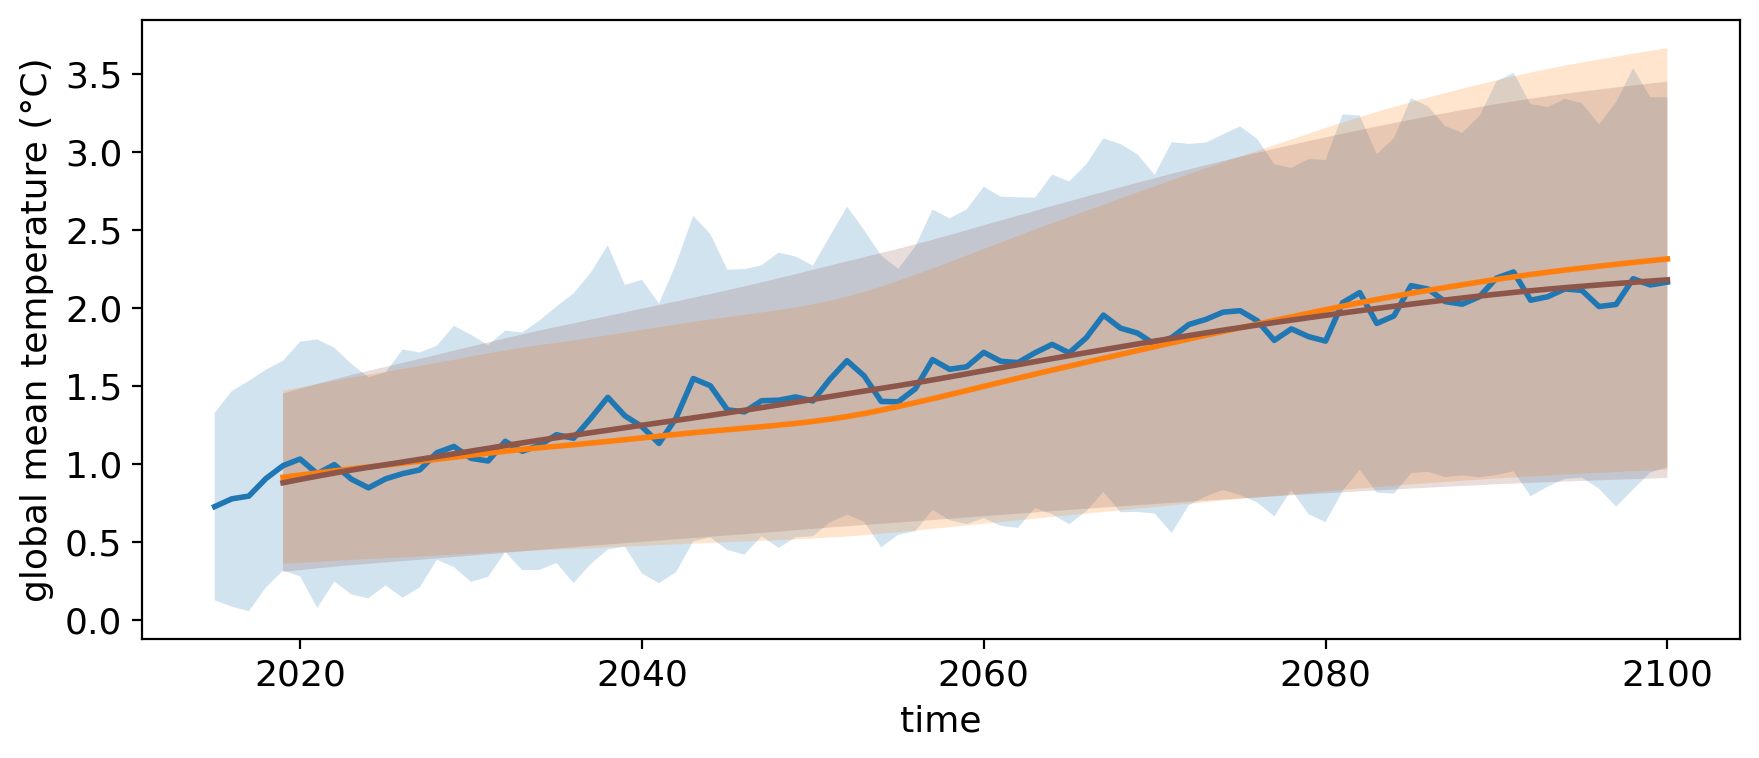

In [21]:
fig,ax = plt.subplots(figsize=(9,4))

global_mean_std_plot(y_test_xr,label='truth',ax=ax,color='tab:blue')
global_mean_std_plot(y_test_mse_pre,label='prediction',ax=ax,color='tab:orange')
global_mean_std_plot(y_test_mae_pre,label='prediction',ax=ax,color='tab:brown')

ax.set_xlabel('time')
ax.set_ylabel('global mean temperature (°C)')
ax.legend()
plt.tight_layout()

In [26]:
# get global mean temperature
def global_mean(X,var='tas'):
    weights  = np.cos(np.deg2rad(X.latitude))
    tas_mean = X['tas'].weighted(weights).mean(['latitude', 'longitude']).data
    return tas_mean

tas_mean_xr = global_mean(y_test_xr)
tas_mean_mse_pre = global_mean(y_test_mse_pre)
tas_mean_mae_pre = global_mean(y_test_mae_pre)

# put into dataframe
df_globalmean_test = pd.DataFrame()
df_globalmean_test["time"] = y_test_xr.sel(latitude=lat,longitude=lon,method='nearest').tas.to_dataframe().index
df_globalmean_test["truth"] = tas_mean_xr
df_globalmean_test["prediction_mse"] = np.nan
df_globalmean_test.loc[4:, "prediction_mse"] = tas_mean_mse_pre # prediction start from 2019
df_globalmean_test["prediction_mae"] = np.nan
df_globalmean_test.loc[4:, "prediction_mae"] = tas_mean_mae_pre # prediction start from 2019
print(df_globalmean_test.head(10))

# summary statistics of the dataframe
df_globalmean_test.describe()

   time     truth  prediction_mse  prediction_mae
0  2015  0.724876             NaN             NaN
1  2016  0.774634             NaN             NaN
2  2017  0.792321             NaN             NaN
3  2018  0.905029             NaN             NaN
4  2019  0.987700        0.913413        0.877829
5  2020  1.030206        0.927096        0.899317
6  2021  0.935918        0.940444        0.920151
7  2022  0.994084        0.953785        0.940278
8  2023  0.900831        0.966889        0.959288
9  2024  0.845252        0.979518        0.976802


,time,truth,prediction_mse,prediction_mae
count,86.000000,86.000000,82.000000,82.000000
mean,2057.500000,1.564246,1.559675,1.580145
std,24.969982,0.430099,0.451818,0.400505
min,2015.000000,0.724876,0.913413,0.877829
25%,2036.250000,1.169074,1.157234,1.235069
50%,2057.500000,1.635698,1.483124,1.586906
75%,2078.750000,1.943204,1.982873,1.948634
max,2100.000000,2.230782,2.314540,2.180389
